In [327]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from numpy.linalg import norm
from cvxopt import solvers, matrix

In [328]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [329]:
def get_p(X,D,kernel='poly',param=2):
    P = []
    variance = np.var(X)
    for i in range(len(D)):
        row = []
        for j in range(len(D)):
            if kernel is 'poly':
                temp = D[i] * D[j] * polynomial_kernel(np.array(X[i]),np.array(X[j]),param)
            elif kernel is 'gaussian':
                temp = D[i] * D[j] * gaussian_kernel(np.array(X[i]),np.array(X[j]),variance)
            elif kernel is 'linear':
                temp = D[i] * D[j] * linear_kernel(np.array(X[i]),np.array(X[j]))               
            row.append(temp)
        P.append(row)
    return P

In [330]:
def get_random_points(a, b, n):
    x = list()
    for i in range(n):
        temp = random.uniform(a, b)
        x.append(temp)
    return x

In [331]:
def get_desired_points(X):
    d = list()
    for x1,x2 in X:
        if (x2 < 1/5 * math.sin(10*x1) + 0.3) or ((x2 - 0.8)**2 + (x1 - 0.5)**2 < (0.15)**2):
            d.append(1)
        else:
            d.append(-1)
    return d

In [332]:
def linear_kernel(xi,xj):
    return np.dot(xi.T,xj)

In [333]:
def polynomial_kernel(Xi,Xj,d):
    return (1 + np.dot(Xi.T,Xj))**d

In [347]:
def gaussian_kernel(Xi,Xj,sigma):
    return math.exp(-(norm(Xi - Xj)**2/(sigma+0.5)**2))

In [348]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [349]:
def get_alpha(X,D,kernel='poly',param=2):
    P= get_p(X,D,kernel,param)
    P = matrix(np.array(P), (len(D),len(D)), 'd')
    q = matrix(-1 * np.ones(len(D)))
    h = matrix(np.zeros(len(D)))
    G = matrix(-1 * np.eye(len(D))) ##
    b = matrix([0], (1,1), 'd')
    A = matrix(D, (1,len(D)) , 'd')
    sol=solvers.qp( P, q, G, h, A, b)
    return (np.array(list(sol['x'])))

In [350]:
#filtering for best 10
def get_support_vector(alpha):
    k= np.argwhere(alpha > 0.0001)
    return k

In [351]:
def get_theta(alpha,X,D,K,kernel='poly',param=2):
    temp = 0
    variance = np.var(X)
    for i in range(len(D)):
        if kernel is 'poly':
             temp += alpha[i] * D[i] * polynomial_kernel(np.array(X[i]),np.array(X[K]),param) # param: degree for poly kernel
        elif kernel is 'linear':
            temp += alpha[i] * D[i] * linear_kernel(np.array(X[i]),np.array(X[K]))
        elif kernel is 'gaussian':
            temp += alpha[i] * D[i] * gaussian_kernel(np.array(X[i]),np.array(X[K]),variance) #parma: not needes , based on the variance
    theta = D[K] - temp
    return theta

In [352]:
def get_gx(alpha,X,D,theta,Ik,Xk,kernel='poly',param=2):
    temp = 0
    variance = np.var(X)
    for i in Ik:
        if kernel is 'poly':
            temp += alpha[i] * D[i] * polynomial_kernel(np.array(X[i]),Xk,param)
        elif kernel is 'linear':
            temp += alpha[i] * D[i] * linear_kernel(np.array(X[i]),Xk)
        elif kernel is 'gaussian':
            temp += alpha[i] * D[i] * gaussian_kernel(np.array(X[i]),Xk,variance)
    g_x = temp + theta
    return(g_x)      

### Getting the input values

In [353]:
X1 = get_random_points(0, 1, 100)
X2 = get_random_points(0, 1, 100)
X = [[ele1,ele2] for ele1,ele2 in zip(X1,X2)]
D = get_desired_points(X)

### Running the cvxopt as quadprog for the decision boundaries

In [354]:
alpha = get_alpha(X,D,'gaussian')
K = get_support_vector(alpha)

     pcost       dcost       gap    pres   dres
 0: -3.8772e+01 -1.1140e+02  3e+02  1e+01  3e+00
 1: -1.0612e+02 -2.0812e+02  2e+02  7e+00  2e+00
 2: -3.0101e+02 -4.4966e+02  2e+02  5e+00  1e+00
 3: -5.2095e+02 -7.1599e+02  2e+02  5e+00  1e+00
 4: -1.3086e+03 -1.6237e+03  4e+02  4e+00  1e+00
 5: -2.4165e+03 -2.9649e+03  6e+02  4e+00  9e-01
 6: -4.5527e+03 -5.5728e+03  1e+03  3e+00  7e-01
 7: -6.0207e+03 -7.2856e+03  1e+03  2e+00  5e-01
 8: -6.9782e+03 -7.5483e+03  6e+02  5e-01  1e-01
 9: -7.0281e+03 -7.0560e+03  3e+01  2e-02  4e-03
10: -7.0312e+03 -7.0321e+03  9e-01  4e-04  8e-05
11: -7.0316e+03 -7.0316e+03  5e-02  4e-06  1e-06
12: -7.0316e+03 -7.0316e+03  9e-04  4e-08  1e-08
Optimal solution found.


In [355]:
theta

-0.2896315144691626

In [356]:
K= [idx for idx,val in enumerate(alpha) if float(val)>0.001]

## Plotting the decision boundaries

##### I am using the gaussian kernel with sigma being the variance in the input values (X)+ 0.5(to adjust the separtaion of the boundaries)

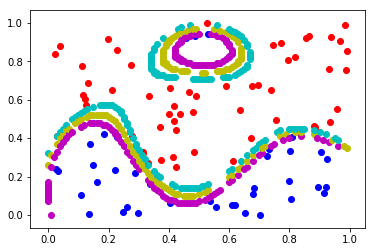

In [359]:
for (x, y), d in zip(X, D):
    if d is 1:
        plt.scatter(x, y, color='b', marker='o')
    elif d is -1:
        plt.scatter(x, y, color='r', marker='o')
theta = get_theta(alpha,X, D, K[1], kernel="gaussian")
new_range = np.arange(0, 1, 0.01)
for x1 in new_range:
    for x2 in new_range:
        g = get_gx(alpha, X, D, theta,Ik=K, Xk=np.array([x1, x2]),kernel= 'gaussian')
        if (g <= 1.1 and g >= 0.9):
            plt.scatter(x1, x2, color='m', marker='o')
        if ((g >= -1.1) and (g <= -0.9)):
            plt.scatter(x1, x2, color='c', marker='o')
        if ((g >= -0.1) and (g <= 0.1)):
            plt.scatter(x1, x2, color='y', marker='o')
plt.show()

##### So Gaussian kernel with variance equal to the variance in the input + value(0.5) to separate the decision boundaries helped to plot the curve.
